# Summary

I developed a LSTM network which predicts the coordinates of the fifth hit in a track. The x,y, and z coordinates of the hits are treated as separate datasets and are input into separate (but structurally identical) networks. The data consists of primary electron tracks (track ID == 1 or track ID == 2) from the first 20 events. I created the network using Keras, an API which runs on top of TensorFlow. I trained the network with five tracks, then tested it on five different tracks. The network is obviously able to output the correct values for the z coordinate of the final hit, since the fifth hit always occurred at the main detector (detector 28). It works reasonably well for the final x coordinates; the percent error between the predicted and expected values is under 16% for all five test tracks. The y coordinate predictions were less successful due to, I believe, the larger variation in the y values in the test data. The least accurate prediction had a percent error of ~48%. This is clearly not ideal; however, the predicted values were all within 20 mm of the actual values, so training the network on more data and tweaking some of the parameters would likely help reduce this issue. 

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

import sklearn
from sklearn.preprocessing import StandardScaler

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler() ## Scales data for easier processing by the algorithm

%matplotlib notebook

/Users/maryrobinson/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Format of track data

First, I created arrays of tracks. Again, the tracks I am using are the primary electron tracks (i.e. those tracks with track ID = 1 or track ID = 2) from the first 20 events. Each array is labeled with the coordinate (x,y,z) and the event number. In one case (event 17), both of the primary electrons were detected, so these arrays have the additional labels 1 and 2. 

# x coordinates

In [2]:
## Input Data - x coordinates
### 10 of the first 20 events are both nonempty and had hits with track IDs 1 or 2

### Event 0:
x_0 = np.array([-712.6236348987155, -743.3650472419545, -989.2963459878656, -1020.0377583311046, -1042.174649359471])

### Event 3:
x_3 = np.array([-498.7284520758689, -516.368100649287, -657.4852892366317, -675.1249378100498, -687.8272487477682])

### Event 5:
x_5 = np.array([166.75338420275833, 173.60381901295943, 228.40729749456844, 235.25773230476955, 240.19073041159538])

### Event 12:
x_12 = np.array([207.3121182841773, 214.5227687881202, 272.20797281966355, 279.4186233236065, 284.61101275149576])

### Event 14:
x_14 = np.array([175.98436685091323, 182.91437027931673, 238.3543977065446, 245.2844011349481, 250.27469660374146])

### Event 15:
x_15 = np.array([596.171671753686, 621.5957689970486, 824.9885469439497, 850.4126441873123, 868.7205366122577])

### Event 16:
x_16 = np.array([-440.1333340701853, -456.10131983680077, -583.8452059697245, -599.81319173634, -611.3117382868797])

### Event 17:
x_17_1 = np.array([759.0224995743883, 784.0867407468246, 984.6006701263146, 1009.6649112987509, 1027.7136713670222])
x_17_2 = np.array([-676.6845553673828, -705.847164075667, -939.1480337419413, -968.3106424502255, -989.3106369810611])

### Event 19:
x_19 = np.array([222.5399965096124, 230.56137117452462, 294.7323684938225, 302.7537431587347, 308.52993505493805])


## Training Set 

I took the first five tracks as my training set. I combined the individual track arrays into one single array (`training_data_x`) where each column corresponded to the "index" of the hit -- i.e. the first column = the first hit, the second column = the second hit, etc. Then, I split the training set into the input values (`train_in_x`, the first four hits in the tracks) and the output values (`train_out_x`, the final hit in the tracks). I scaled the data using scikit-learn's `StandardScaler` function, which makes the data normally distributed. Since there are a wide range of coordinate values in the tracks, scaling makes it easier for the network to learn. 

In [3]:
## Array of training data for the x coordinates:
### Training data consists of the first five tracks above (this choice is arbitrary)
### First column = first hit, second column = second hit, etc. 

training_data_x = np.stack((x_0, x_3, x_5, x_12,x_14))

## Separate training data into input and output
### Input = first four columns (i.e. first four hits in each of the tracks)

train_in_x = training_data_x[:,0:4]


### Scale training input:
scaler_train_in_x = scaler.fit(train_in_x)
train_in_x = scaler_train_in_x.transform(train_in_x)


### Reshape training input -- Desired shape = (#Samples, #Timesteps, #Features)
train_in_x = train_in_x.reshape(5,4,1)

#print train_in_x

### Output = fifth column (i.e. the final hit in each of the tracks)

train_out_x = training_data_x[:,4:5]


### Scale training output:
scaler_train_out_x = scaler.fit(train_out_x)
train_out_x = scaler_train_out_x.transform(train_out_x)

### Reshape training output -- Desired Shape = (#Samples, #Features)
train_out_x = train_out_x.reshape(5,1)

#print train_out_x

## Description of the Model

-  `model = Sequential( )` : This is a network that consists of a linear stack of layers. 

    -  The input shape needs to be specified in the first layer of the model. The input array has shape (# Samples, # Timesteps, # Features) -- in this case, (5, 4, 1). However, the model only needs to be told the number of timesteps and the number of features, so (4,1) is given as the input shape.
    
-  `model.add(LSTM())` : Long Short Term Memory (LSTM) is a type of recurrent neural network (RNN) which  was developed to deal with sequential data that has long term dependencies.

    -  Arguments:
    
        -  The first number given is the dimensionality of the output space of this layer. I played around with this, using values I saw commonly used in code written by others. I chose 128 because the higher dimensions seemed to yield better results. I want to investigate this more to see how much of an effect it actually has.
        
        -  `input_shape` - since the LSTM layer is the first layer in this network, the input shape (described above) is given here.
        
-  `model.add(Dense())`: This is a fully connected layer. 
    
    -  Arguments:
    
        -  Again, the first number given is the dimensionality of the output space of this layer. This is the final layer in the network, so the dimension is the dimension of our desired output. A single output is being predicted for each input, so, in this case, the dimension is 1.
        
        -  `activation` - Here, the desired activation function is specified. This network uses a linear activation. 
        
-  `model.compile()`- This forms the learning process for the network. 

    -  Arguments:
    
        -  `loss`- The loss (error) function used. In this case, the function is mean squared error (`mse`). 
        
        -  `optimizer`- The optimization algorithm used. In this case, the network uses Adam (`adam`) optimizer. 
        
        -  `metrics`- This tells the model which values to keep track of while it is training. This model keeps track of the mean squared error. 
        
-  `model.fit()`: Trains the model 

    -  Arguments:
    
        -  The first argument is the training input array (ex. `train_in_x`).
        
        -  The second argument is the training output array (ex. `train_out_x`).
        
        -  `epochs` - the number of times that the entire dataset is fed through the network - in this case, 1000. This is another parameter that I tweaked several times, as I did for the dimensionality of the output space in the LSTM layer. 
        
        -  `shuffle` = `True` or `False`; tells the network whether or not to shuffle the data 
         
        -  `verbose` = `0` or `1`; if 0, then the training progress is not printed. If 1, then the training progress is printed.
    
    

In [20]:
## Build the model

model = Sequential()

### LSTM layer -- 
### The first number given is the dimensionality of the output space; higher dimensions, in this case, seem to yield 
### better results
### input_shape: since this is the first layer, the shape of the input data is specified here. Only the number of 
### timesteps and the number of features need to be given. 
model.add(LSTM(128, input_shape=(4,1)))

### Dense layer --
### Again, first number given is the dimensionality of the output space. This should match the dimensionality of the 
### training output, since it is the last layer. 
### activation = 'linear': linear activation function is the identity function 
model.add(Dense(1,activation='linear'))

### Compile the model --
### loss = 'mse': Mean squared error loss
### optimizer = 'adam': Adam (adaptive moment) optimizer
### metrics = ['mse']: Keeps track of mean squared error metric (since this is regression, not classification)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

Fit the model:

<IPython.core.display.Javascript object>


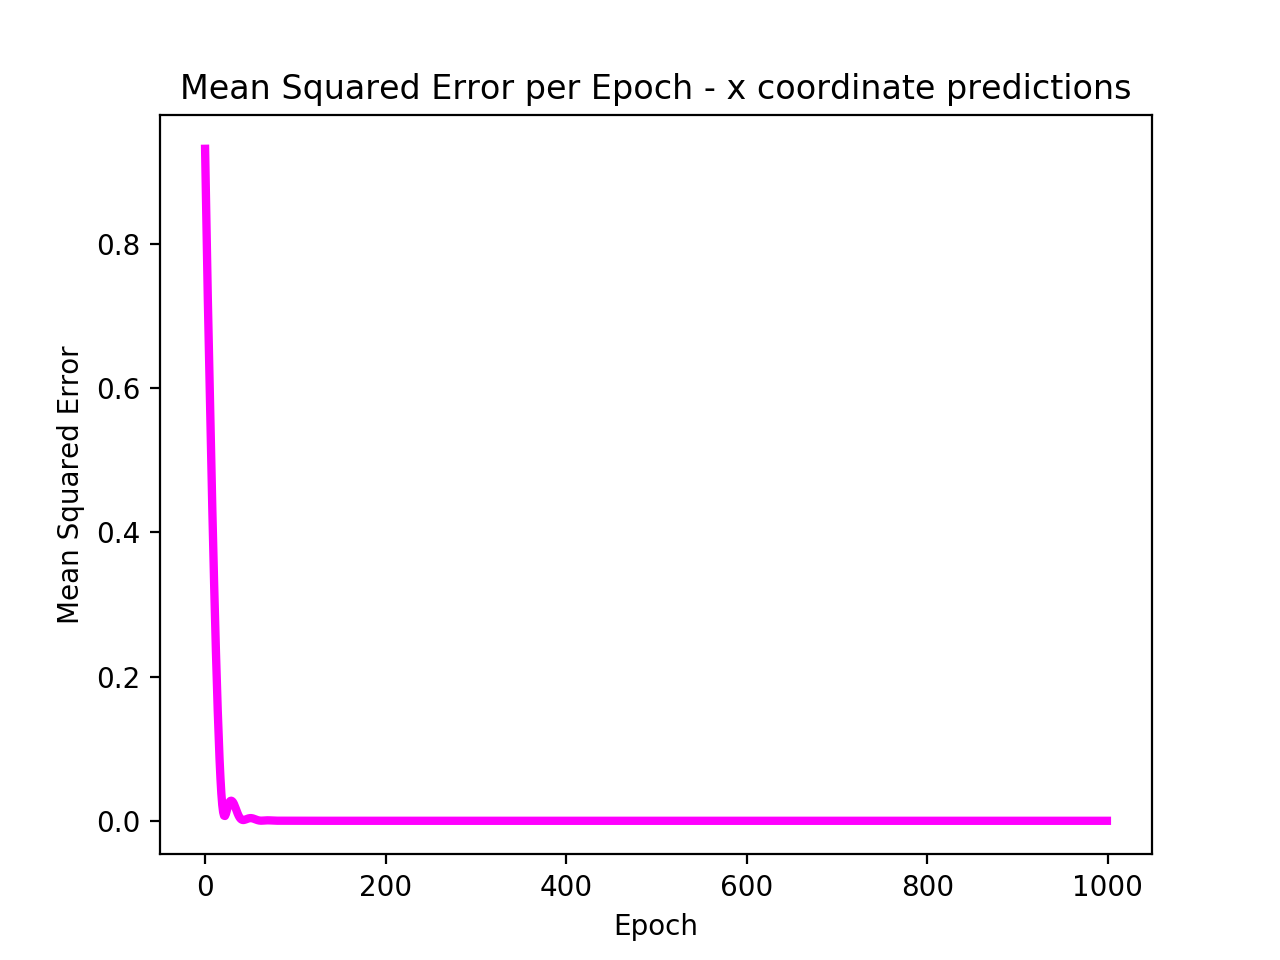

Text(0.5,1,'Mean Squared Error per Epoch - x coordinate predictions')

In [21]:
## Fit the model
### model.fit (INPUT DATA, OUTPUT DATA, # Epochs, Shuffle? True/False, Print progress? 1 = yes 0 = no)
history = model.fit(train_in_x, train_out_x, epochs=1000, shuffle=False,verbose=0)

## Plot of the mean squared error per epoch:

plt.figure(num="Figure 1")
plt.plot(history.history['mean_squared_error'], color='magenta', linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error per Epoch - x coordinate predictions")


## Test Set

Now, we want to see how well the model performs on unseen data, so I created a test dataset out of the remaining five tracks. I split and scaled the data using the same approach I used for the training set. 

-  `model.predict()` - Shows how well the model performs on a test dataset.
    -  Arguments:
        -  The first argument is the test data input. 
        - `verbose` - again, set to 0 to supress printing of progress. 

   Actual Value  Percent Error  Predicted Value
0    868.720537       4.633618       828.467346
1   -611.311738       1.527033      -601.976807
2   1027.713671       4.371025       982.792053
3   -989.310637       0.353674      -985.811707
4    308.529935      16.555620       359.608978


<IPython.core.display.Javascript object>


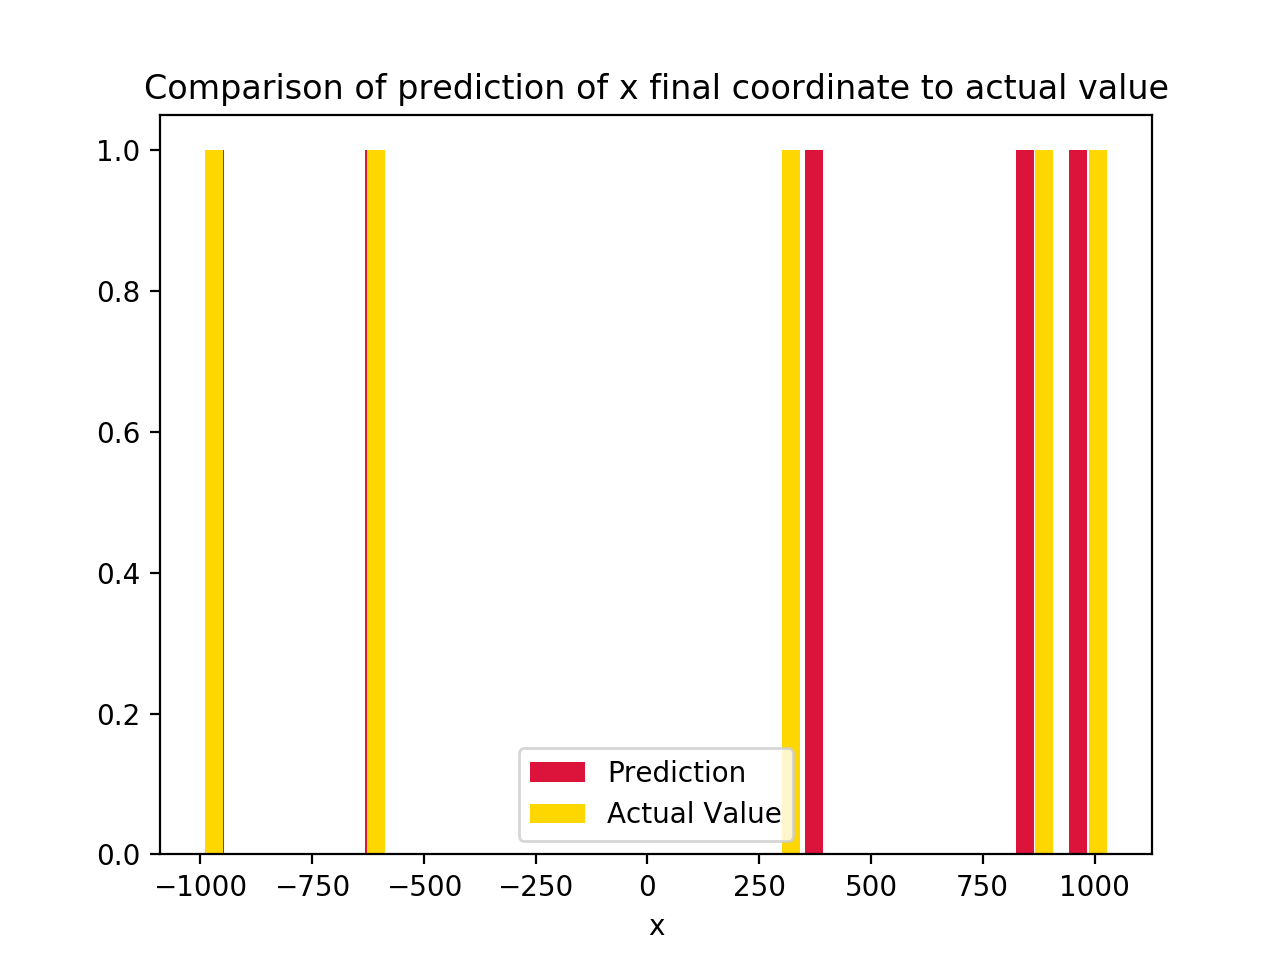

Text(0.5,0,'x')

In [22]:
## Create test dataset:
test_data_x = np.stack((x_15, x_16, x_17_1, x_17_2, x_19))


## Separate test dataset into input and output sets; these are formatted and scaled the same was as the training data

### Test input:
test_in_x = test_data_x[:,0:4]

scaler_test_in_x = scaler.fit(test_in_x)
test_in_x = scaler_test_in_x.transform(test_in_x)

test_in_x = test_in_x.reshape(5,4,1)


### Test output:
test_out_x = test_data_x[:,4:5]

test_out_x = test_out_x.reshape(5,1)

scaler_test_out_x = scaler.fit(test_out_x)

test_out_x = scaler_test_out_x.transform(test_out_x)


## Use the model to predict outputs for the test data
### model.predict(TEST INPUT, show progress? 1=yes 0=no)
pred_x = model.predict(test_in_x, verbose=0)

## Unscale the prediction for comparison to actual values:
pred_unscaled_x = scaler_test_out_x.inverse_transform(pred_x)

test_output_true_x = test_data_x[:,4:5]

pred_unscaled_x = list(pred_unscaled_x.flatten())

test_output_true_x = list(test_output_true_x.flatten())

percent_error_x = [0,0,0,0,0]

for i in range(0,5):
    percent_error_x[i] = abs((pred_unscaled_x[i]-test_output_true_x[i])/test_output_true_x[i])*100
    

x_pred_comp = {"Predicted Value": pred_unscaled_x, "Actual Value": test_output_true_x, "Percent Error": percent_error_x}

x_pred_comp = pd.DataFrame(data=x_pred_comp)

print x_pred_comp

## Histogram comparing the predicted value to the actual value of the x coordinate:
plt.figure(num="Figure 2")
plt.hist(pred_unscaled_x,bins=50, color="crimson", label="Prediction")
plt.hist(test_output_true_x, bins=50, color="gold", label="Actual Value")
plt.legend()
plt.title("Comparison of prediction of x final coordinate to actual value")
plt.xlabel("x")

I used an identical network structure for the y and the z coordinates. The code and outputs are shown below:

# y coordinates

In [23]:
## Input Data - y coordinates
### 10 of the first 20 events are both nonempty and had hits with track IDs 1 or 2

### Event 0:
y_0 = np.array([-8.545840621199806, -8.910113776517962, -11.824299019063208, -12.188572174381363, -12.450885273525966])

### Event 3:
y_3 = np.array([-557.6277430029236, -576.8053777774609, -730.2264559737591, -749.4040907482964, -763.2139055494407])

### Event 5:
y_5 = np.array([605.5367075243571, 630.4801562521591, 830.0277460745742, 854.9711948023762, 872.9329722312663])

### Event 12:
y_12 = np.array([-707.3186570282202, -730.5649701799341, -916.5354753936452, -939.7817885453592, -956.5214586459084])

### Event 14:
y_14 = np.array([-690.4941943185381, -717.1495481369722, -930.3923786844445, -957.0477325028785, -976.2422527875327])

### Event 15:
y_15 = np.array([-283.1470200553743, -295.15372706215135, -391.20738311636774, -403.21409012314473, -411.8601198387248])

### Event 16:
y_16 = np.array([-584.9398672808048, -606.3830746441524, -777.9287335509337, -799.3719409142813, -814.813194536628])

### Event 17:
y_17_1 = np.array([21.68995693211888, 25.81966272177004, 58.85730903897933, 62.98701482863049, 65.9608159677583])
y_17_2 = np.array([20.29209131563918, 21.054443394888047, 27.153260028878986, 27.915612108127853, 28.464581840394963])

### Event 19:
y_19 = np.array([701.760848207923, 725.3316316781282, 913.8978994397697, 937.468682909975, 954.4420040868698])


<IPython.core.display.Javascript object>


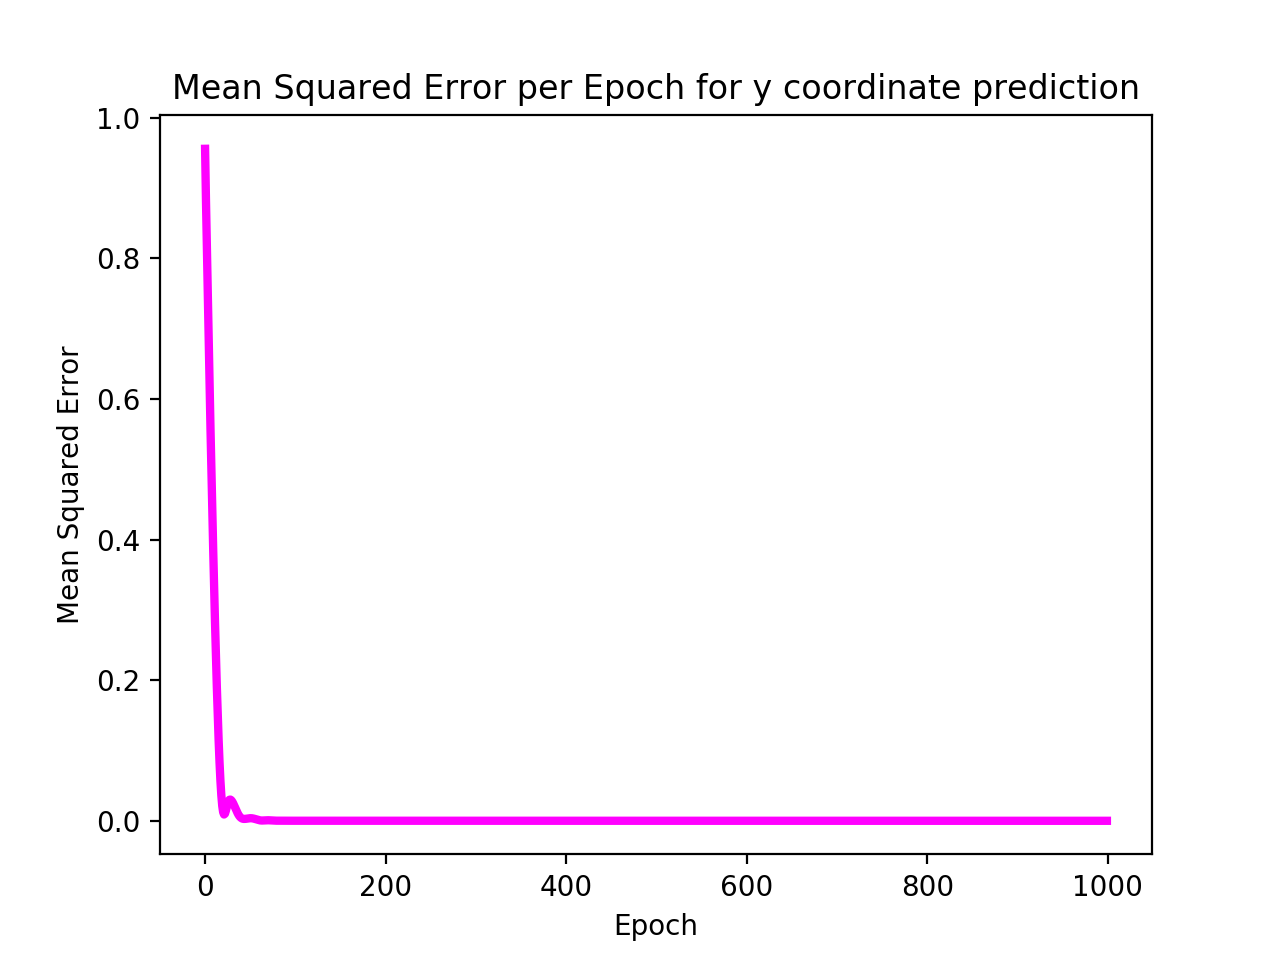

   Actual Value  Percent Error  Predicted Value
0   -411.860120       1.449147      -405.891663
1   -814.813195       5.546584      -769.618896
2     65.960816      51.557706        31.952932
3     28.464582      45.063606        15.637415
4    954.442004       1.347007       967.298401


<IPython.core.display.Javascript object>


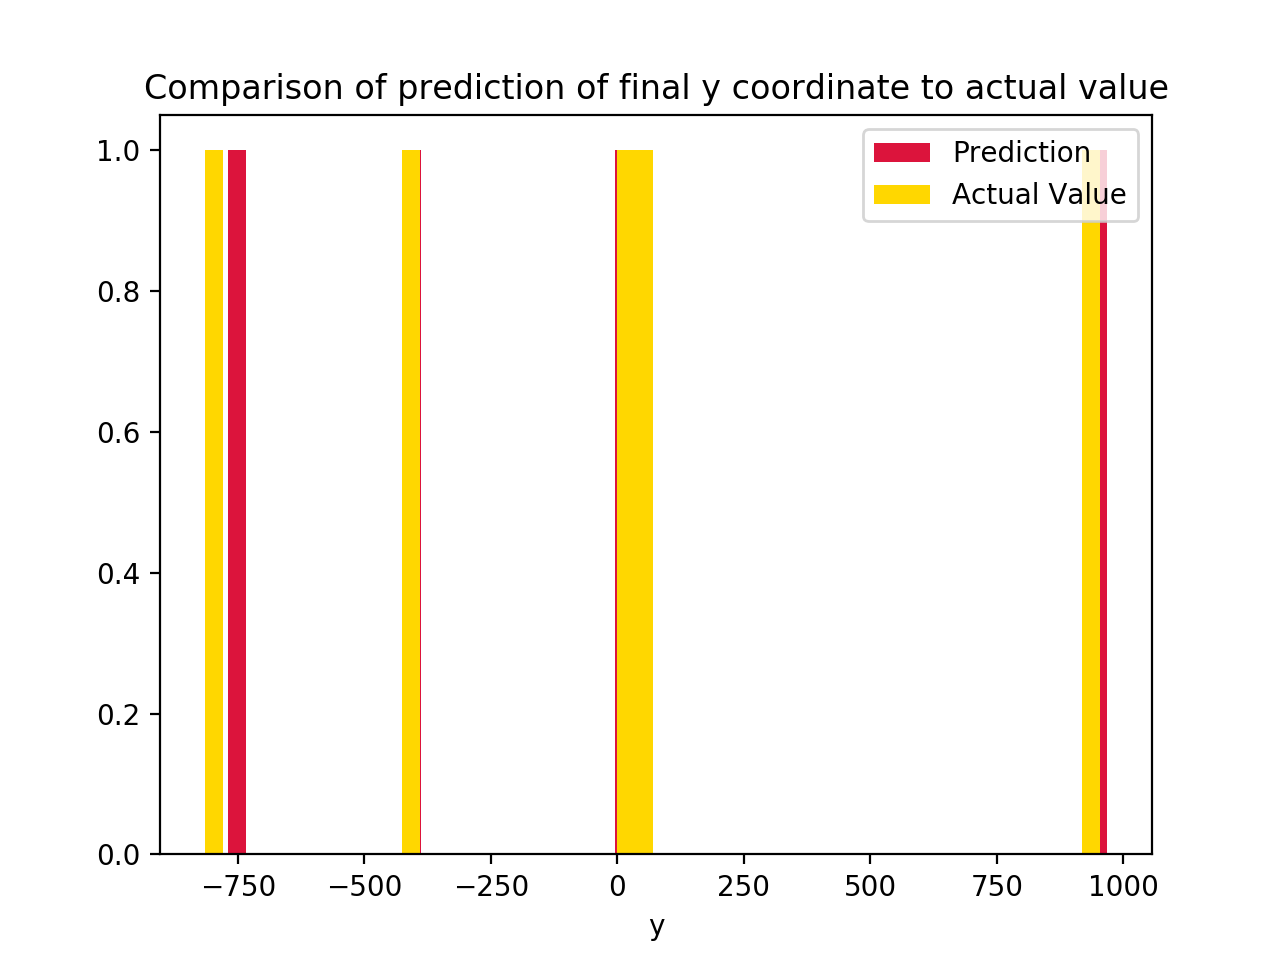

Text(0.5,0,'y')

In [25]:
## Array of training data for the y coordinates:
### Training data consists of the first five tracks above (this choice is arbitrary)
### First column = first hit, second column = second hit, etc. 

training_data_y = np.stack((y_0, y_3, y_5, y_12,y_14))

## Separate training data into input and output
### Input = first four columns (i.e. first four hits in each of the tracks)

train_in_y = training_data_y[:,0:4]


### Scale training input:
scaler_train_in_y = scaler.fit(train_in_y)
train_in_y = scaler_train_in_y.transform(train_in_y)


### Reshape training input -- Desired shape = (#Samples, #Timesteps, #Features)
train_in_y = train_in_y.reshape(5,4,1)

#print train_in

### Output = fifth column (i.e. the final hit in each of the tracks)

train_out_y = training_data_y[:,4:5]

### Scale training output:
scaler_train_out_y = scaler.fit(train_out_y)
train_out_y = scaler_train_out_y.transform(train_out_y)

### Reshape training output -- Desired Shape = (#Samples, #Features)
train_out_y = train_out_y.reshape(5,1)

#print train_out_y

#-------------------------------------------------------------------------------------------------------------------
 
## Build the model

model = Sequential()

### LSTM layer -- 
### The first number given is the dimensionality of the output space; higher dimensions, in this case, seem to yield 
### better results
### input_shape: since this is the first layer, the shape of the input data is specified here. Only the number of 
### timesteps and the number of features need to be given. 
model.add(LSTM(128, input_shape=(4,1)))

### Dense layer --
### Again, first number given is the dimensionality of the output space. This should match the dimensionality of the 
### training output, since it is the last layer. 
### activation = 'linear': linear activation function is the identity function 
model.add(Dense(1,activation='linear'))

### Compile the model --
### loss = 'mse': Mean squared error loss
### optimizer = 'adam': Adam (adaptive moment) optimizer
### metrics = ['mse']: Keeps track of mean squared error metric (since this is regression, not classification)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


#-------------------------------------------------------------------------------------------------------------------

## Fit the model
### model.fit (INPUT DATA, OUTPUT DATA, # Epochs, Shuffle? True/False, Print progress? 1 = yes 0 = no)
history = model.fit(train_in_y, train_out_y, epochs=1000, shuffle=False,verbose=0)

## Plot of the mean squared error per epoch:

plt.figure(num="Figure 3")
plt.plot(history.history['mean_squared_error'],color='magenta', linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error per Epoch for y coordinate prediction")

#-------------------------------------------------------------------------------------------------------------------

## Create test dataset:
test_data_y = np.stack((y_15, y_16, y_17_1, y_17_2, y_19))

## Separate test dataset into input and output sets; these are formatted and scaled the same was as the training data

### Test input:
test_in_y = test_data_y[:,0:4]

scaler_test_in_y = scaler.fit(test_in_y)
test_in_y = scaler_test_in_x.transform(test_in_y)

test_in_y = test_in_y.reshape(5,4,1)


### Test output:
test_out_y = test_data_y[:,4:5]

test_out_y = test_out_y.reshape(5,1)

scaler_test_out_y = scaler.fit(test_out_y)

test_out_y = scaler_test_out_y.transform(test_out_y)

#-------------------------------------------------------------------------------------------------------------------

## Use the model to predict outputs for the test data
### model.predict(TEST INPUT, show progress? 1=yes 0=no)
pred_y = model.predict(test_in_y, verbose=0)


## Unscale the prediction for comparison to actual values:
pred_unscaled_y = scaler_test_out_y.inverse_transform(pred_y)

test_output_true_y = test_data_y[:,4:5]

pred_unscaled_y = list(pred_unscaled_y.flatten())

test_output_true_y = list(test_output_true_y.flatten())

percent_error_y = [0,0,0,0,0]

for i in range(0,5):
    percent_error_y[i] = abs((pred_unscaled_y[i]-test_output_true_y[i])/test_output_true_y[i])*100

y_pred_comp = {"Predicted Value": pred_unscaled_y, "Actual Value": test_output_true_y, "Percent Error": percent_error_y}

y_pred_comp = pd.DataFrame(data=y_pred_comp)

print y_pred_comp

## Histogram comparing the predicted value to the actual value of the y coordinate:
plt.figure(num="Figure 4")
plt.hist(pred_unscaled_y, bins=50, color="crimson", label="Prediction")
plt.hist(test_output_true_y, bins=50, color="gold", label="Actual Value")
plt.legend()
plt.title("Comparison of prediction of final y coordinate to actual value")
plt.xlabel("y")


# z coordinates

In [26]:
## Input Data - z coordinates
### 10 of the first 20 events are both nonempty and had hits with track IDs 1 or 2

### Event 0:
z_0 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 3:
z_3 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 5:
z_5 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 12:
z_12 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 14:
z_14 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 15:
z_15 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 16:
z_16 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 17:
z_17_1 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])
z_17_2 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])

### Event 19:
z_19 = np.array([23134.95, 23634.95, 27634.95, 28134.95, 28495.0])


<IPython.core.display.Javascript object>


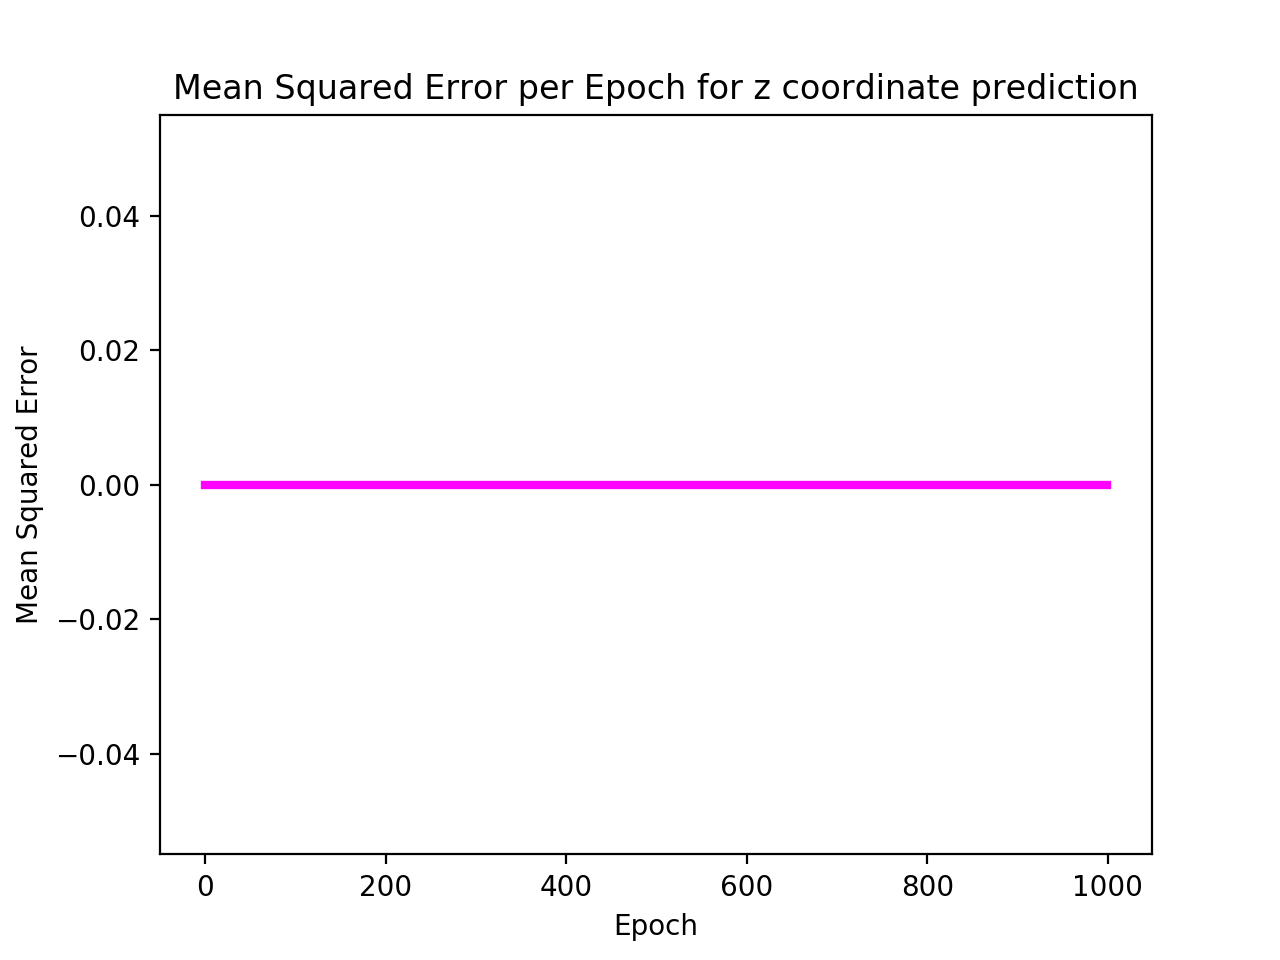

   Actual Value  Percent Error  Predicted Value
0       28495.0            0.0          28495.0
1       28495.0            0.0          28495.0
2       28495.0            0.0          28495.0
3       28495.0            0.0          28495.0
4       28495.0            0.0          28495.0


<IPython.core.display.Javascript object>


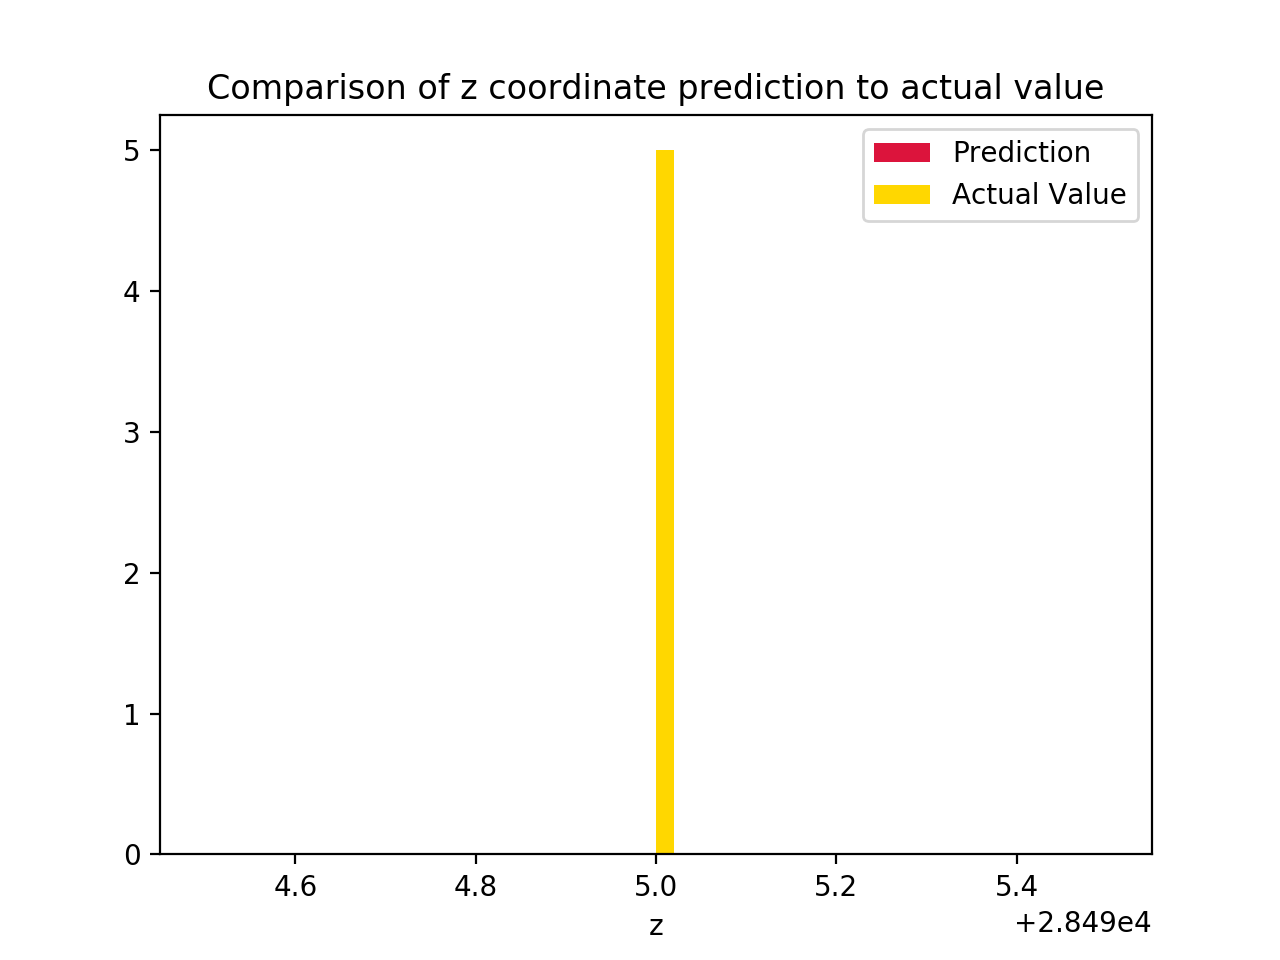

Text(0.5,0,'z')

In [27]:
## Array of training data for the z coordinates:
### Training data consists of the first five tracks above (this choice is arbitrary)
### First column >>> first hit, second column >>> second hit, etc. 

training_data_z = np.stack((z_0, z_3, z_5, z_12,z_14))

## Separate training data into input and output
### Input = first four columns (i.e. first four hits in each of the tracks)

train_in_z = training_data_z[:,0:4]


### Scale training input:
scaler_train_in_z = scaler.fit(train_in_z)
train_in_z = scaler_train_in_z.transform(train_in_z)


### Reshape training input -- Desired shape = (#Samples, #Timesteps, #Features)
train_in_z = train_in_z.reshape(5,4,1)

#print train_in_z

### Output = fifth column (i.e. the final hit in each of the tracks)

train_out_z = training_data_z[:,4:5]

### Scale training output:
scaler_train_out_z = scaler.fit(train_out_z)
train_out_z = scaler_train_out_z.transform(train_out_z)

### Reshape training output -- Desired Shape = (#Samples, #Features)
train_out_z = train_out_z.reshape(5,1)

#print train_out_z

#-------------------------------------------------------------------------------------------------------------------

## Build the model

model = Sequential()

### LSTM layer -- 
### The first number given is the dimensionality of the output space; higher dimensions, in this case, seem to yield 
### better results
### input_shape: since this is the first layer, the shape of the input data is specified here. Only the number of 
### timesteps and the number of features need to be given. 
model.add(LSTM(128, input_shape=(4,1)))

### Dense layer --
### Again, first number given is the dimensionality of the output space. This should match the dimensionality of the 
### training output, since it is the last layer. 
### activation = 'linear': linear activation function is the identity function 
model.add(Dense(1,activation='linear'))

### Compile the model --
### loss = 'mse': Mean squared error loss
### optimizer = 'adam': Adam (adaptive moment) optimizer
### metrics = ['mse']: Keeps track of mean squared error metric (since this is regression, not classification)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#-------------------------------------------------------------------------------------------------------------------

## Fit the model
### model.fit (INPUT DATA, OUTPUT DATA, # Epochs, Shuffle? True/False, Print progress? 1 = yes 0 = no)
history = model.fit(train_in_z, train_out_z, epochs=1000, shuffle=False,verbose=0)

## Plot of the mean squared error per epoch:

plt.figure(num="Figure 5")
plt.plot(history.history['mean_squared_error'],color='magenta', linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error per Epoch for z coordinate prediction")


#-------------------------------------------------------------------------------------------------------------------

## Create test dataset:
test_data_z = np.stack((z_15, z_16, z_17_1, z_17_2, z_19))

## Separate test dataset into input and output sets; these are formatted and scaled the same was as the training data

### Test input:
test_in_z = test_data_z[:,0:4]

scaler_test_in_z = scaler.fit(test_in_z)
test_in_z = scaler_test_in_z.transform(test_in_z)

test_in_z = test_in_z.reshape(5,4,1)


### Test output:
test_out_z = test_data_z[:,4:5]

test_out_z = test_out_z.reshape(5,1)

scaler_test_out_z = scaler.fit(test_out_z)

test_out_z = scaler_test_out_z.transform(test_out_z)

#-------------------------------------------------------------------------------------------------------------------

## Use the model to predict outputs for the test data
### model.predict(TEST INPUT, show progress? 1=yes 0=no)
pred_z = model.predict(test_in_z, verbose=0)

## Unscale the prediction for comparison to actual values:
pred_unscaled_z = scaler_test_out_z.inverse_transform(pred_z)

test_output_true_z = test_data_z[:,4:5]

pred_unscaled_z = list(pred_unscaled_z.flatten())

test_output_true_z = list(test_output_true_z.flatten())

percent_error_z = [0,0,0,0,0]

for i in range(0,5):
    percent_error_z[i] = abs((pred_unscaled_z[i]-test_output_true_z[i])/test_output_true_z[i])*100
    

z_pred_comp = {"Predicted Value": pred_unscaled_z, "Actual Value": test_output_true_z, "Percent Error": percent_error_z}

z_pred_comp = pd.DataFrame(data=z_pred_comp)

print z_pred_comp

## Histogram comparing the predicted value to the actual value of the x coordinate:
plt.figure(num="Figure 6")
plt.hist(pred_unscaled_z, bins=50, color="crimson", label="Prediction")
plt.hist(test_output_true_z, bins=50, color="gold", label="Actual Value")
plt.legend()
plt.title("Comparison of z coordinate prediction to actual value")
plt.xlabel("z")


# Predicted vs. Actual Tracks 

I made plots of each of the actual test tracks as well as the predicted tracks for easy visual analysis of the network's performance.

<IPython.core.display.Javascript object>


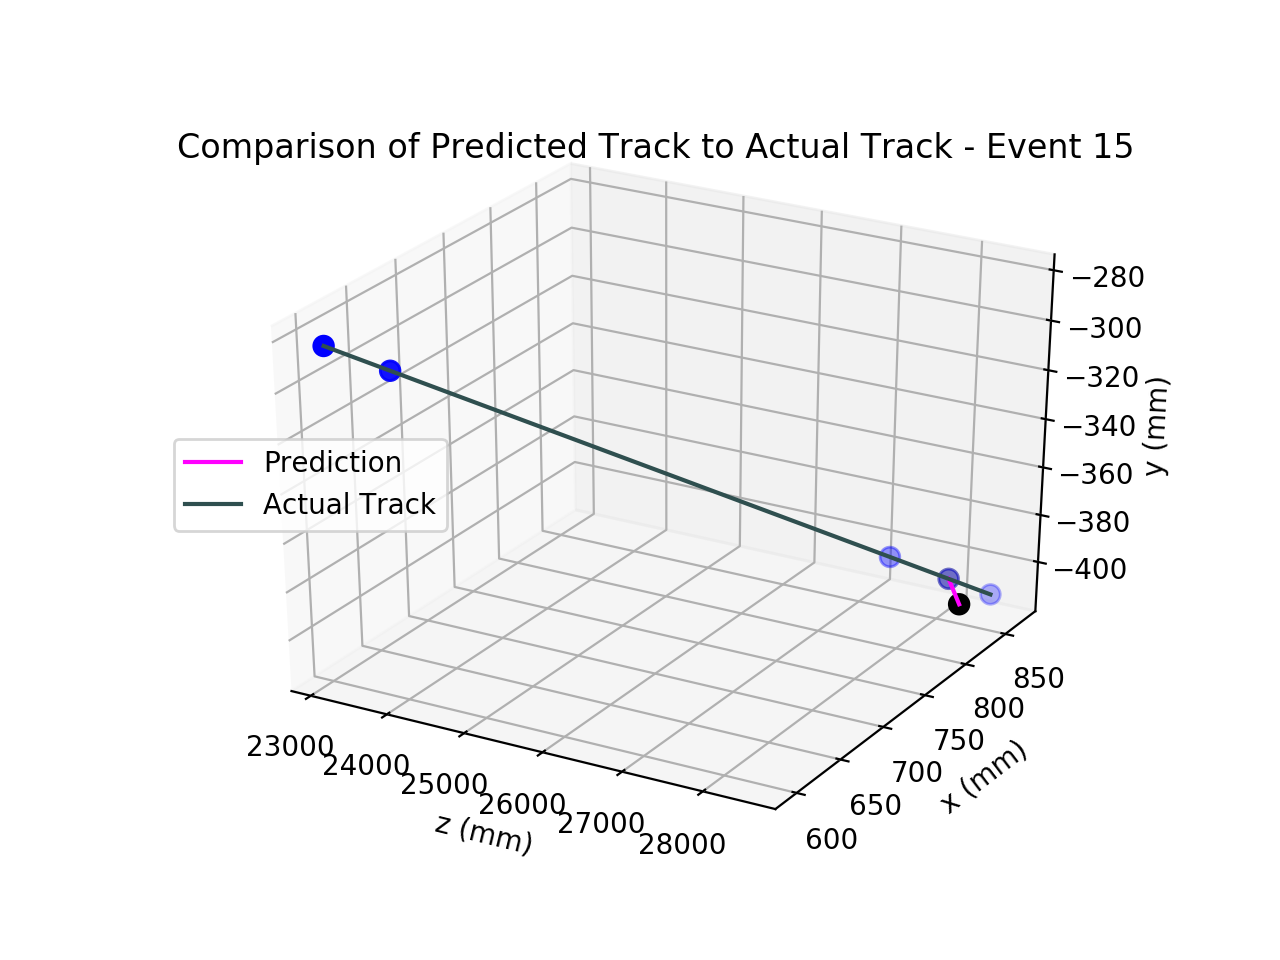

Text(0.5,0.92,'Comparison of Predicted Track to Actual Track - Event 15')

In [28]:
## Plot of Event 15 - predicted track and actual track

test_track_15_x = np.array([x_15[3], pred_unscaled_x[0]])
test_track_15_y = np.array((y_15[3], pred_unscaled_y[0]))
test_track_15_z = np.array((z_15[3], pred_unscaled_z[0]))

%matplotlib notebook
plt.figure(num="Figure 7")
ax = plt.axes(projection='3d')
ax.scatter(test_track_15_z, test_track_15_x, test_track_15_y, s=50, color="black")
ax.plot3D(test_track_15_z, test_track_15_x, test_track_15_y, color="magenta", label="Prediction")
ax.scatter(z_15,x_15,y_15, s=50, color="blue")
ax.plot3D(z_15,x_15,y_15, color="darkslategrey", label="Actual Track")
ax.set_xlabel("z (mm)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")
ax.legend(loc="center left")
ax.set_title("Comparison of Predicted Track to Actual Track - Event 15")

<IPython.core.display.Javascript object>


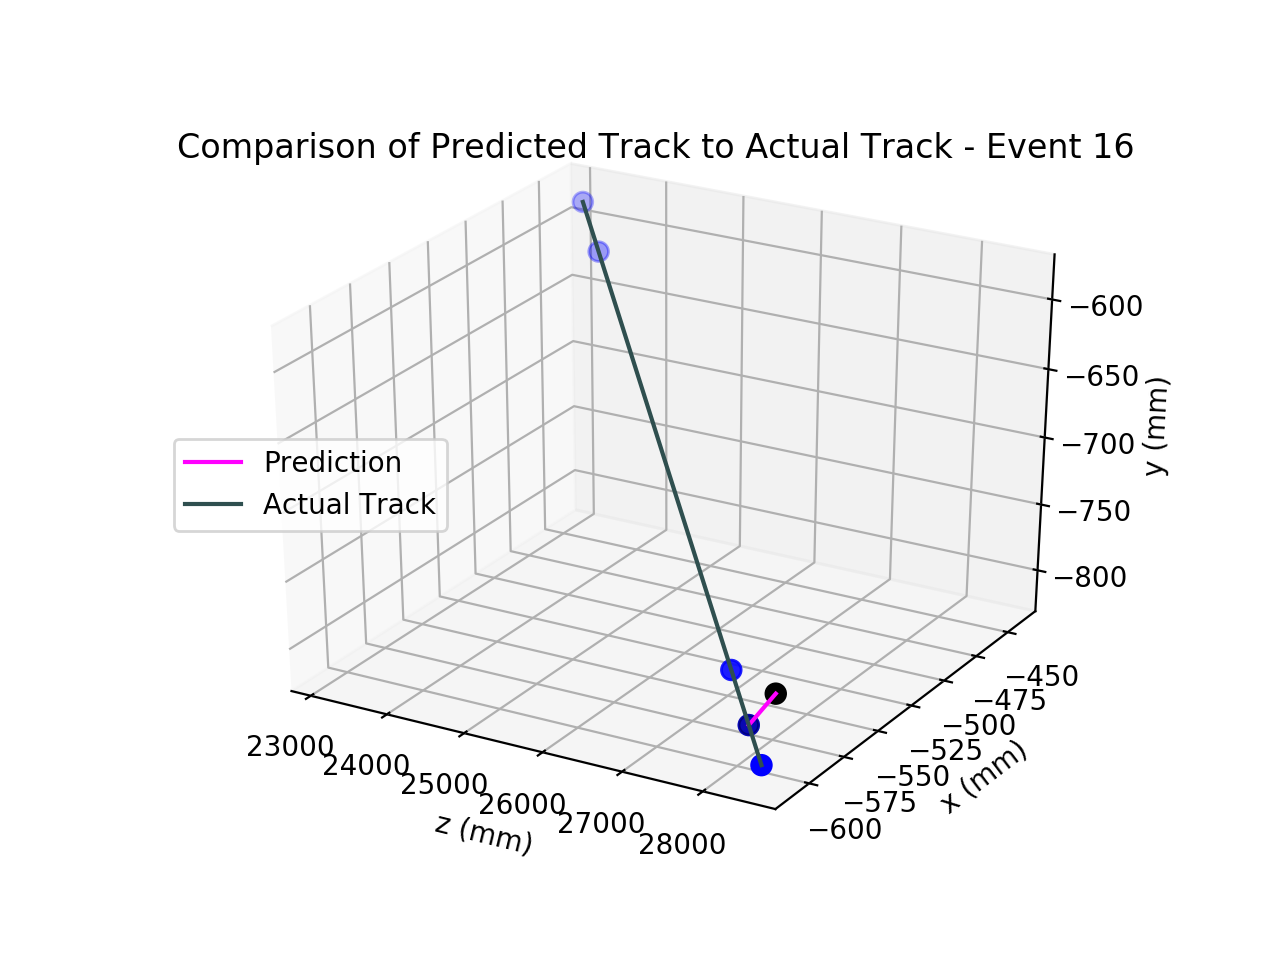

Text(0.5,0.92,'Comparison of Predicted Track to Actual Track - Event 16')

In [29]:
## Plot of Event 16 - predicted track and actual track

test_track_16_x = np.array([x_16[3], pred_unscaled_x[1]])
test_track_16_y = np.array((y_16[3], pred_unscaled_y[1]))
test_track_16_z = np.array((z_16[3], pred_unscaled_z[1]))


plt.figure(num="Figure 8")
ax = plt.axes(projection='3d')
ax.scatter(test_track_16_z, test_track_16_x, test_track_16_y, s=50, color="black")
ax.plot3D(test_track_16_z, test_track_16_x, test_track_16_y, color="magenta", label="Prediction")
ax.scatter(z_16,x_16,y_16, s=50, color="blue")
ax.plot3D(z_16,x_16,y_16, color="darkslategrey", label="Actual Track")
ax.set_xlabel("z (mm)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")
ax.legend(loc="center left")
ax.set_title("Comparison of Predicted Track to Actual Track - Event 16")

<IPython.core.display.Javascript object>


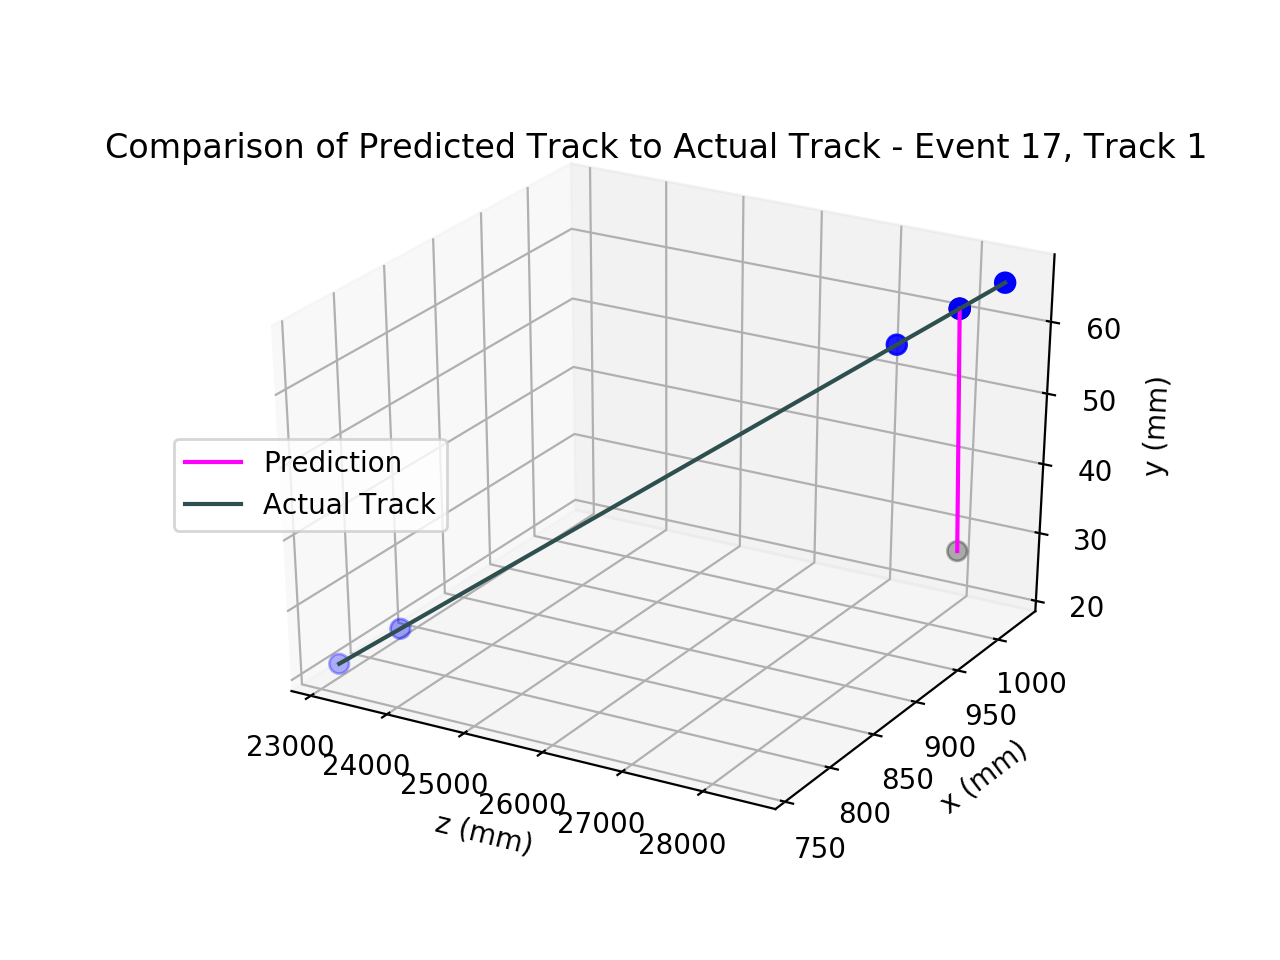

Text(0.5,0.92,'Comparison of Predicted Track to Actual Track - Event 17, Track 1')

In [30]:
## Plot of Event 17, track id =1 - predicted track and actual track

test_track_17_1_x = np.array([x_17_1[3], pred_unscaled_x[2]])
test_track_17_1_y = np.array((y_17_1[3], pred_unscaled_y[2]))
test_track_17_1_z = np.array((z_17_1[3], pred_unscaled_z[2]))


plt.figure(num="Figure 9")
ax = plt.axes(projection='3d')
ax.scatter(test_track_17_1_z, test_track_17_1_x, test_track_17_1_y, s=50, color="black")
ax.plot3D(test_track_17_1_z, test_track_17_1_x, test_track_17_1_y, color="magenta", label="Prediction")
ax.scatter(z_17_1,x_17_1,y_17_1, s=50, color="blue")
ax.plot3D(z_17_1,x_17_1,y_17_1, color="darkslategrey", label="Actual Track")
ax.set_xlabel("z (mm)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")
ax.legend(loc="center left")
ax.set_title("Comparison of Predicted Track to Actual Track - Event 17, Track 1")

<IPython.core.display.Javascript object>


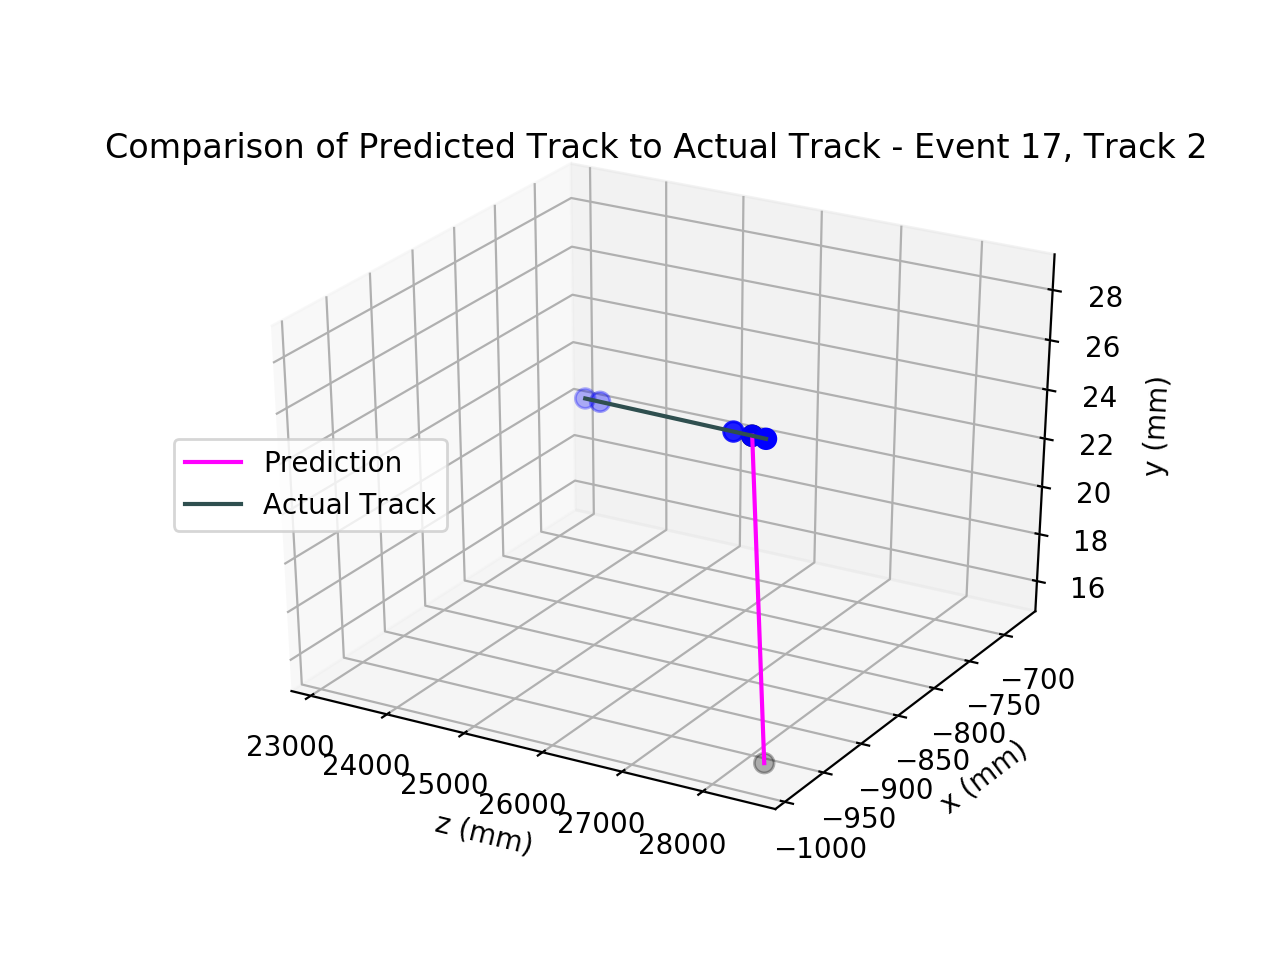

Text(0.5,0.92,'Comparison of Predicted Track to Actual Track - Event 17, Track 2')

In [31]:
## Plot of Event 17, track id = 2 - predicted track and actual track

test_track_17_2_x = np.array([x_17_2[3], pred_unscaled_x[3]])
test_track_17_2_y = np.array((y_17_2[3], pred_unscaled_y[3]))
test_track_17_2_z = np.array((z_17_2[3], pred_unscaled_z[3]))


plt.figure(num="Figure 9")
ax = plt.axes(projection='3d')
ax.scatter(test_track_17_2_z, test_track_17_2_x, test_track_17_2_y, s=50, color="black")
ax.plot3D(test_track_17_2_z, test_track_17_2_x, test_track_17_2_y, color="magenta", label="Prediction")
ax.scatter(z_17_2,x_17_2,y_17_2, s=50, color="blue")
ax.plot3D(z_17_2,x_17_2,y_17_2, color="darkslategrey", label="Actual Track")
ax.set_xlabel("z (mm)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")
ax.legend(loc="center left")
ax.set_title("Comparison of Predicted Track to Actual Track - Event 17, Track 2")

<IPython.core.display.Javascript object>


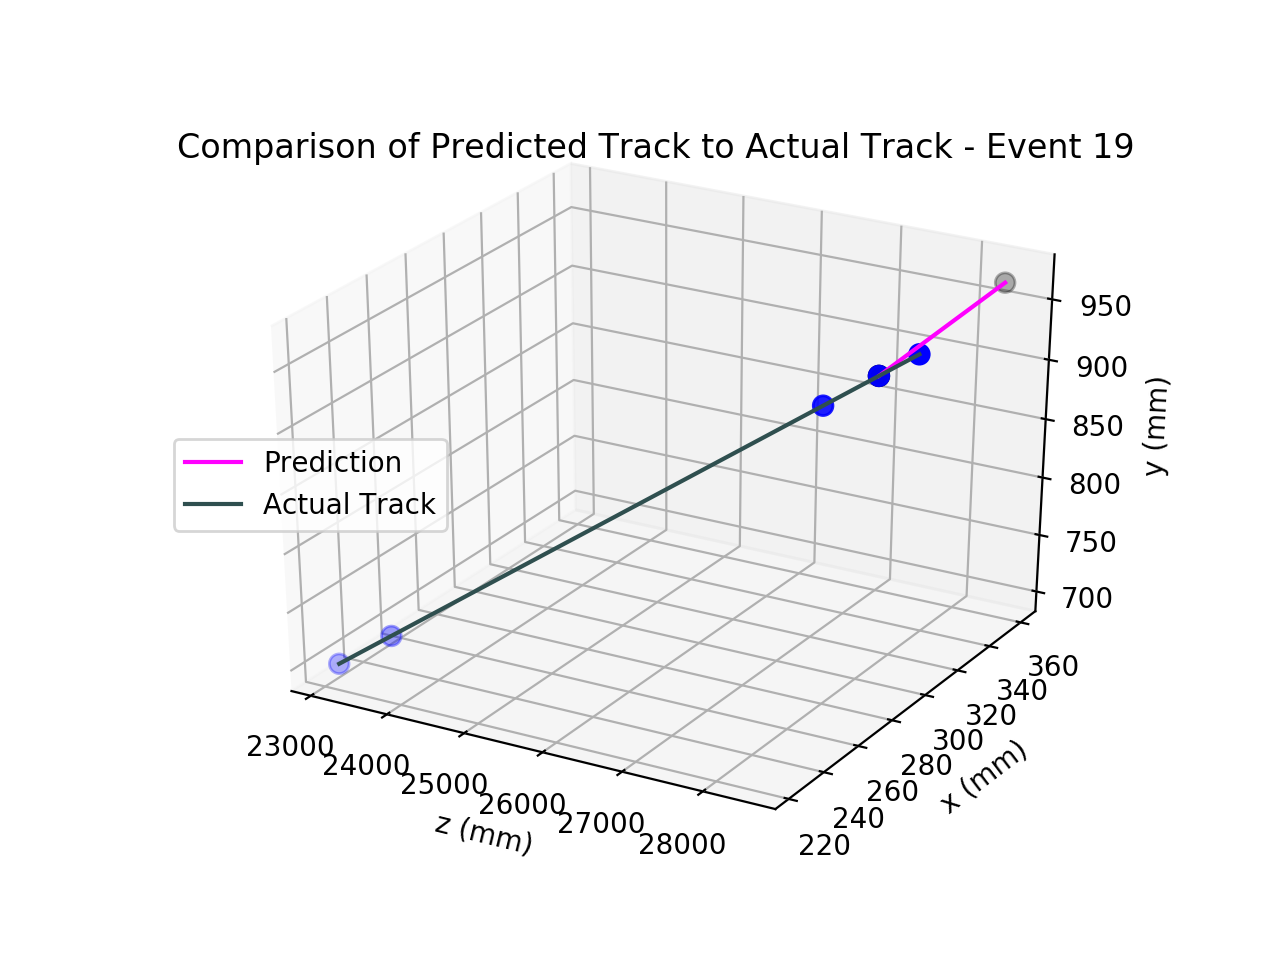

Text(0.5,0.92,'Comparison of Predicted Track to Actual Track - Event 19')

In [32]:
## Plot of Event 19 - predicted track and actual track

test_track_19_x = np.array([x_19[3], pred_unscaled_x[4]])
test_track_19_y = np.array((y_19[3], pred_unscaled_y[4]))
test_track_19_z = np.array((z_19[3], pred_unscaled_z[4]))


plt.figure(num="Figure 10")
ax = plt.axes(projection='3d')
ax.scatter(test_track_19_z, test_track_19_x, test_track_19_y, s=50, color="black")
ax.plot3D(test_track_19_z, test_track_19_x, test_track_19_y, color="magenta", label="Prediction")
ax.scatter(z_19,x_19,y_19, s=50, color="blue")
ax.plot3D(z_19,x_19,y_19, color="darkslategrey", label="Actual Track")
ax.set_xlabel("z (mm)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")
ax.legend(loc="center left")
ax.set_title("Comparison of Predicted Track to Actual Track - Event 19")

# Conclusion

This network performed reasonably when making predictions on separate coordinate sequences. The percent error was high in a few cases, but the predictions were within 20 mm of the actual values, so this issue could likely be fixed by training the network with more than five tracks. In addition, when the individual coordinate predictions are combined and plotted against the actual tracks, it is clear that this error adds up. The predicted final coordinate for event 19, for instance, is very far from the actual value. This issue could also be solved by training with more data. 

The other problem with this approach is that the x, y, and z coordinates are fed into separate models, and then the outputs are recombined. I hope to develop a single model which takes the entire positions, not just single components, of the hits. I believe this will mostly be a matter of figuring out the best way to shape the input and output data. 

# References

__[LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)__

__[Making Predictions with LSTM Models in Keras](https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/)__

__[Reshaping Input Data for LSTM Models in Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)__

__[Time Series Predictions with LSTM Models in Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)__

__[Keras Documentation](https://keras.io/)__

__[Wikipedia - Long Short Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory)__

